In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import random
import os

SEED = 42
random.seed(SEED)           # Seed for Python's random module
np.random.seed(SEED)        # Seed for NumPy
tf.random.set_seed(SEED)    # Seed for TensorFlow

# Ensure TensorFlow operations are deterministic
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Load and preprocess the data
data = pd.read_csv("model_data.csv")
data = data.drop(columns=['Unnamed: 0'])
X = data.drop(columns=['target_cost'])
y = data['target_cost']

# Scale data
scaler = StandardScaler()
X_scaled = X #scaler.fit_transform(X)

# Split Data into training, validation, test sets
# 80%:10%:10% ~roughly
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=(12/57), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Using TensorFlow backend


In [2]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/',histogram_freq=1)
# Define the model
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],))) # Input layer
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=10, max_value=150, step=5),
                               activation=hp.Choice('activation_' + str(i), ['relu', 'tanh', 'sigmoid', 'elu', 'swish']),
                               kernel_regularizer=l2(0.01))) # l2 regularization))
        model.add(BatchNormalization())  # Batch Normalization
        model.add(Dropout(0.5))  # Dropout
        
    model.add(layers.Dense(1)) # Output layer
    
    rates = [0.01, 0.001, 0.0001]

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', rates)),
                  loss='mse',
                  metrics=['mae'])
    
    return model

# Create early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=30,
    executions_per_trial=2,
    directory='model_dir',
    project_name='target_cost_tuning'
)

# Search for the best model
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



# Train the best model on the full training data
history = best_model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]), epochs=350, batch_size=5, validation_data=(X_val, y_val), callbacks=tb_callback)

# Save the model
best_model.save("best_model.keras")


Trial 30 Complete [00h 00m 07s]
val_mae: 0.8243391811847687

Best val_mae So Far: 0.5461780875921249
Total elapsed time: 00h 03m 30s
Epoch 1/350
11/11 [==============================] - 1s 32ms/step - loss: 3.2414 - mae: 0.8757 - val_loss: 2.6462 - val_mae: 0.6514
Epoch 2/350
11/11 [==============================] - 0s 16ms/step - loss: 3.2830 - mae: 0.8504 - val_loss: 2.3669 - val_mae: 0.6676
Epoch 3/350
11/11 [==============================] - 0s 17ms/step - loss: 3.2316 - mae: 0.9181 - val_loss: 2.4204 - val_mae: 0.6133
Epoch 4/350
11/11 [==============================] - 0s 16ms/step - loss: 2.9924 - mae: 0.7656 - val_loss: 2.3080 - val_mae: 0.5842
Epoch 5/350
11/11 [==============================] - 0s 17ms/step - loss: 2.9100 - mae: 0.7633 - val_loss: 2.2038 - val_mae: 0.4493
Epoch 6/350
11/11 [==============================] - 0s 16ms/step - loss: 2.9197 - mae: 0.8067 - val_loss: 2.0565 - val_mae: 0.5171
Epoch 7/350
11/11 [==============================] - 0s 17ms/step - loss: 2

In [3]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 105)               2205      
                                                                 
 batch_normalization (BatchN  (None, 105)              420       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 105)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               15900     
                                                                 
 batch_normalization_1 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 150)               0

In [4]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Input layer details
input_shape = best_model.layers[0].input_shape
print(f"Input layer shape: {input_shape[1]}")

# Details of hidden layers
print(f"The optimal number of layers is {best_hps.get('num_layers')}.")
for i in range(best_hps.get('num_layers')):
    print(f"The optimal number of units in layer {i+1} is {best_hps.get('units_' + str(i))}.")

# Output layer details
output_shape = best_model.layers[-1].output_shape
print(f"Output layer shape: {output_shape[1]}")

print(f"The optimal learning rate is {best_hps.get('learning_rate')}.")

# Try 128 layer 1

Input layer shape: 20
The optimal number of layers is 2.
The optimal number of units in layer 1 is 105.
The optimal number of units in layer 2 is 150.
Output layer shape: 1
The optimal learning rate is 0.01.


Validation Set

In [5]:

# Predictions
y_pred = best_model.predict(X_val)

# Metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print("Val MAE:", mae)
print("Val MSE:", mse)
print("Val RMSE:", rmse)
print("Val R^2:", r2)
print("Val MAPE:", mape)



1/1 [==============================] - 0s 83ms/step
Val MAE: 0.5474041931567557
Val MSE: 0.49349269036203164
Val RMSE: 0.7024903489458283
Val R^2: 0.46721656961756
Val MAPE: 0.9902548314322953


Test Set

In [6]:

# Predictions
y_pred = best_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
residuals = y_test - y_pred.squeeze()

print("Test MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test R^2:", r2)
print("Test MAPE:", mape)


1/1 [==============================] - 0s 21ms/step
Test MAE: 0.738914799349375
Test MSE: 1.292040747493658
Test RMSE: 1.136679703123821
Test R^2: -0.44831790914263325
Test MAPE: 1.8898446600593097


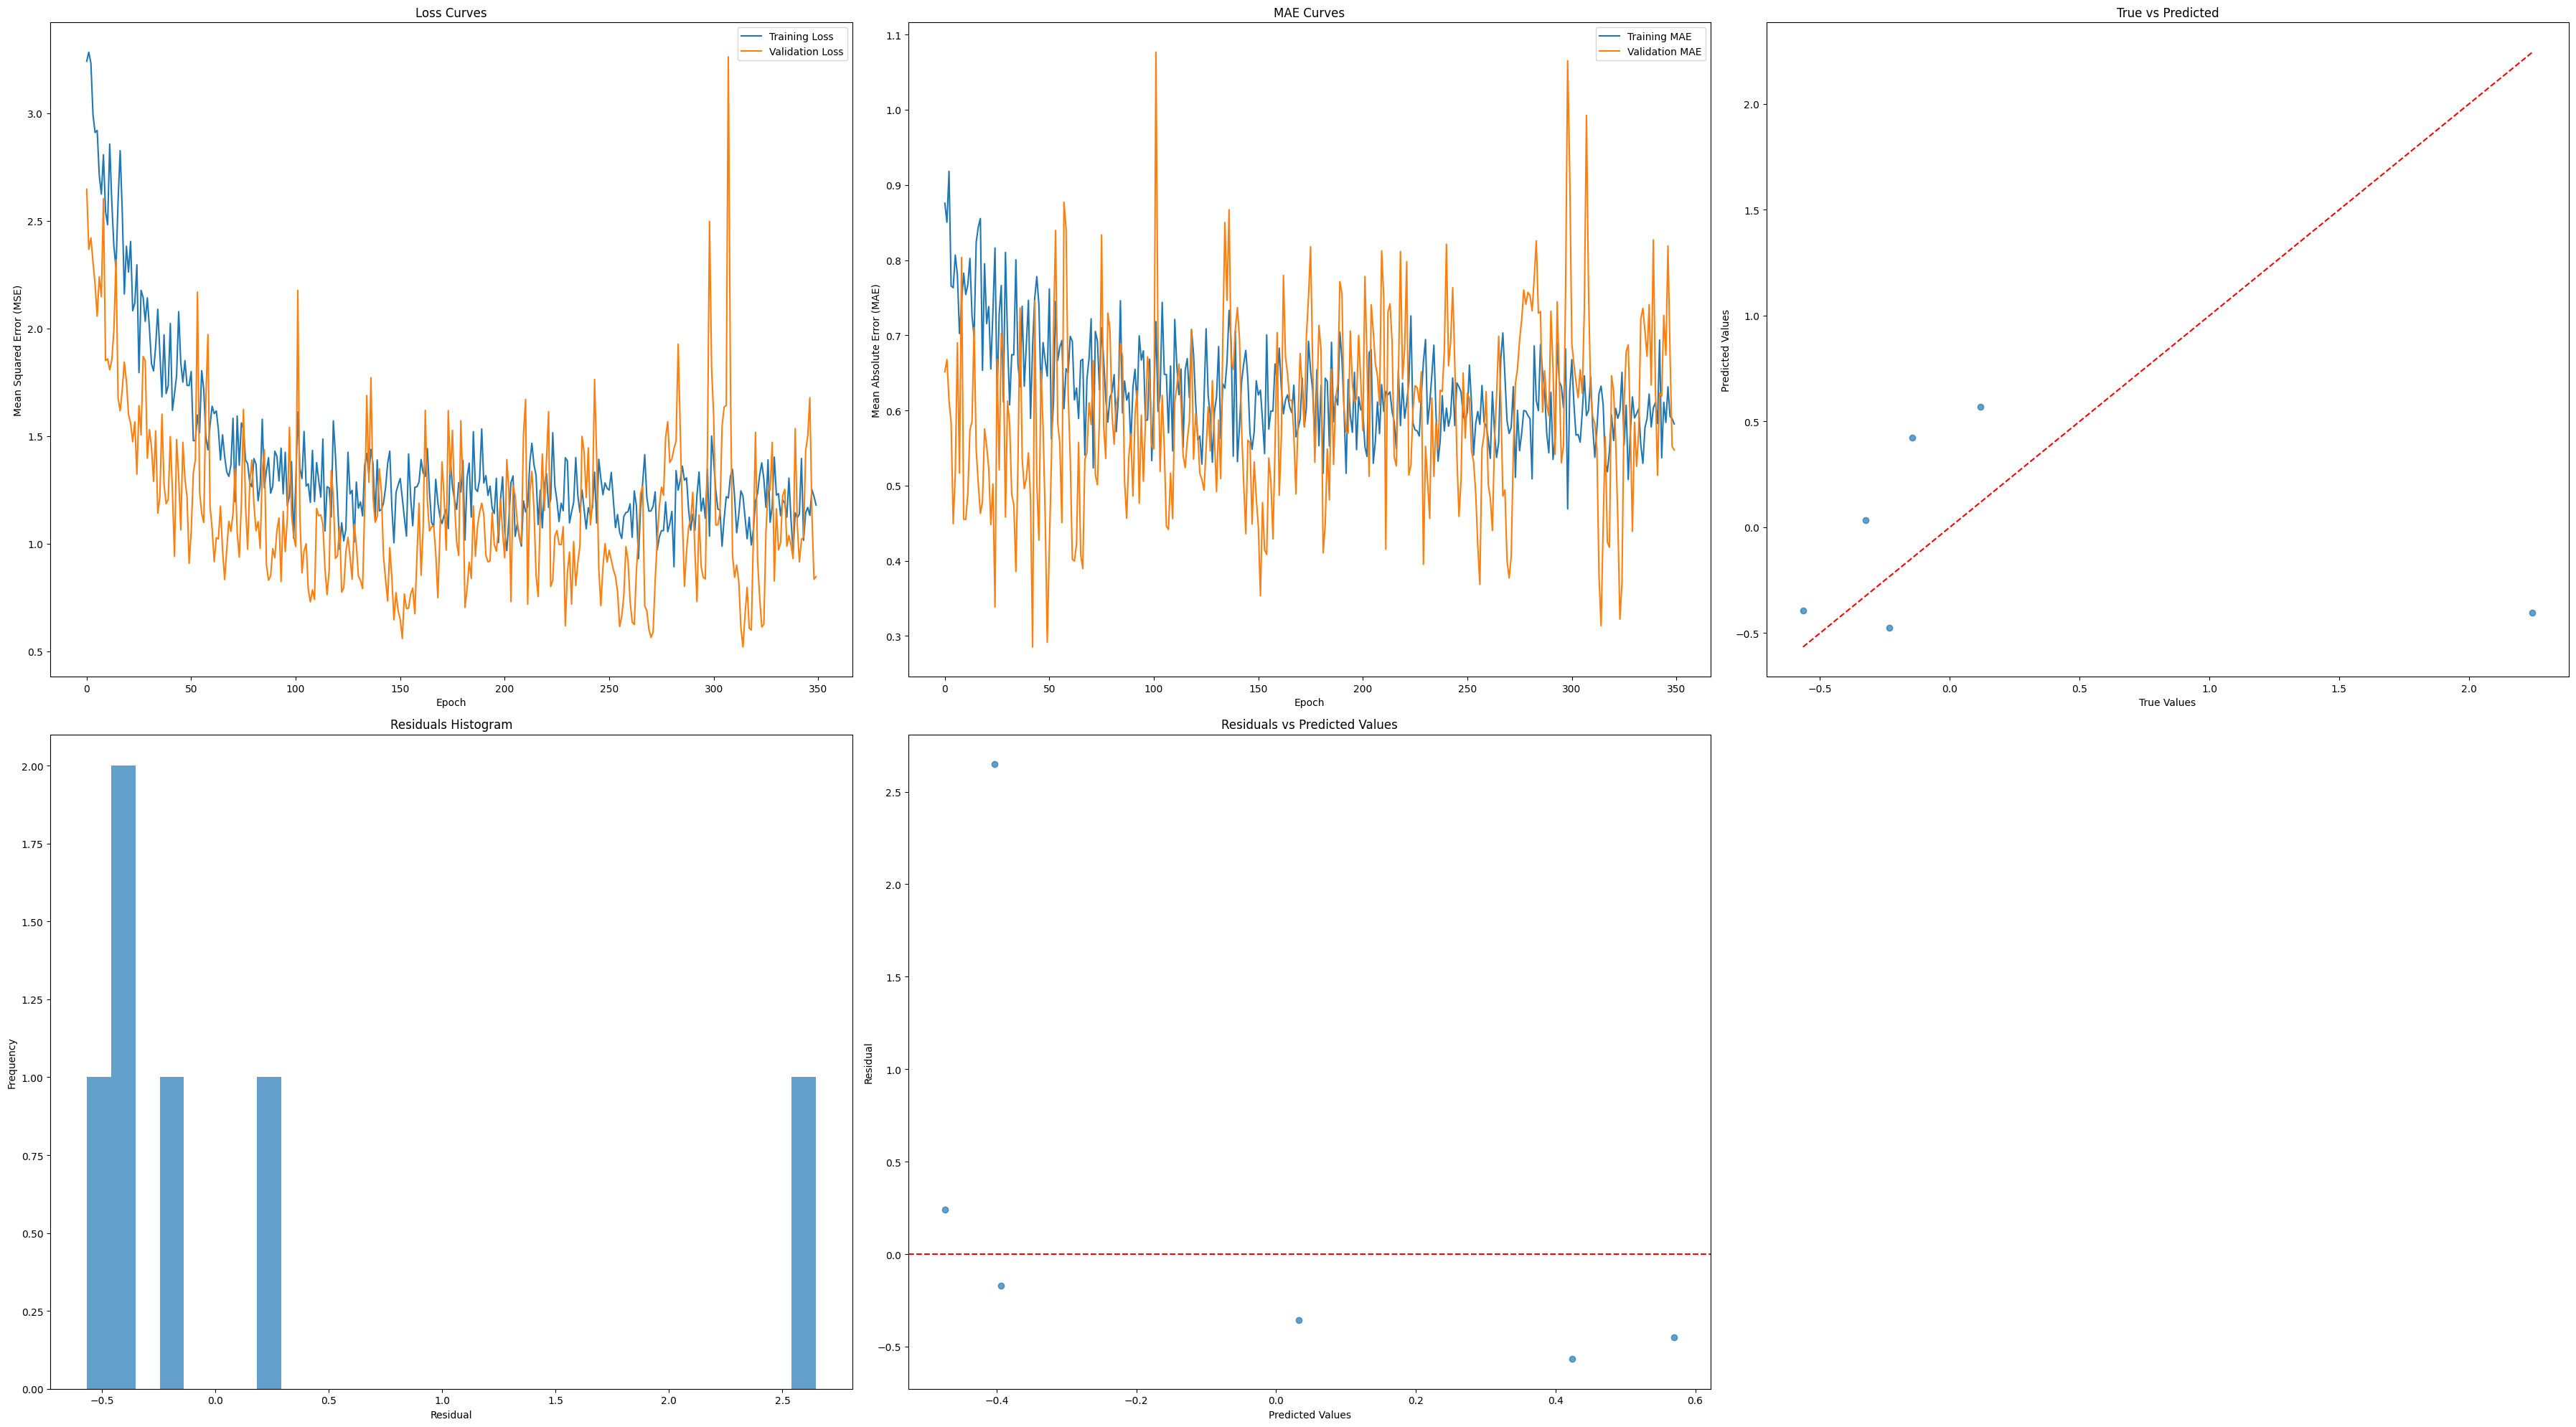

In [7]:

# Plotting
plt.figure(figsize=(36, 20))

# Loss Curves
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# MAE Curves
plt.subplot(2, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

# True vs Predicted
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')

# Residuals Histogram
plt.subplot(2, 3, 4)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')

# Residuals Plot
plt.subplot(2, 3, 5)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()


In [8]:
# Predictions
y_preds = best_model.predict(X_test)

y_preds


1/1 [==============================] - 0s 21ms/step


array([[-0.3939063 ],
       [-0.40355894],
       [ 0.03257453],
       [ 0.56985164],
       [-0.474157  ],
       [ 0.4240171 ]], dtype=float32)

In [9]:
y_test

47   -0.565764
12    2.244818
0    -0.323041
45    0.119366
55   -0.234381
30   -0.143361
Name: target_cost, dtype: float64

### Manual Model

In [10]:
#from sklearn.model_selection import train_test_split

#data2 = pd.read_csv("model_data.csv")

# Drop the 'Unnamed: 0' column
#data2 = data.drop(columns=['Unnamed: 0'])

# Splitting the dataset into training and testing sets
#X = data2.drop(columns=['target_cost'])
#y = data2['target_cost']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train.shape, X_test.shape


In [11]:
#import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [12]:
# Initialize the model
model2 = Sequential()

# Add input layer
model2.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],)))

# Add two hidden layers
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))

# Add output layer
model2.add(Dense(1))

# optimizer settings
optimizer2 = tf.keras.optimizers.Adam(learning_rate=.01)

# Compile the model
model2.compile(optimizer=optimizer2, loss='mse', metrics=['mae'])

# Summary of the model architecture
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 128)               2688      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,429
Trainable params: 11,429
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model2.fit(X_train, y_train, epochs=100, batch_size=5, validation_split=0.1, verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 1.3915 - mae: 0.8674 - val_loss: 0.6168 - val_mae: 0.7441
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9423 - mae: 0.6359 - val_loss: 0.1789 - val_mae: 0.3644
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7182 - mae: 0.4935 - val_loss: 0.3137 - val_mae: 0.4433
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.4722 - mae: 0.4217 - val_loss: 0.1963 - val_mae: 0.3759
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3538 - mae: 0.3460 - val_loss: 0.0488 - val_mae: 0.1951
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2675 - mae: 0.2767 - val_loss: 0.4618 - val_mae: 0.5360
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1392 - mae: 0.2273 - val_loss: 0.6823 - val_mae: 0.6040
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0535 - mae: 0.1547 - va

In [14]:
loss, mae = model2.evaluate(X_test, y_test, verbose=1)
print(f"Mean Absolute Error on Test Set: {mae}")


1/1 [==============================] - 0s 78ms/step - loss: 3.3186 - mae: 1.3433
Mean Absolute Error on Test Set: 1.3432860374450684
